In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_excel('Base de datos v1.xlsx')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Cliente               20000 non-null  int64  
 1   Edad                     19700 non-null  float64
 2   Genero                   20000 non-null  object 
 3   Estado_Civil             20000 non-null  object 
 4   Ingreso_Mensual          19500 non-null  float64
 5   Transacciones_Mensuales  20000 non-null  int64  
 6   Monto_Promedio_Compra    19800 non-null  float64
 7   Uso_Linea_Credito_Pct    20000 non-null  float64
 8   Pagos_Atrasados          20000 non-null  int64  
 9   Antiguedad_Meses         20000 non-null  int64  
 10  Productos_Adicionales    20000 non-null  int64  
 11  Fuga                     20000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1.8+ MB


In [6]:
data.describe()

,ID_Cliente,Edad,Ingreso_Mensual,Transacciones_Mensuales,Monto_Promedio_Compra,Uso_Linea_Credito_Pct,Pagos_Atrasados,Antiguedad_Meses,Productos_Adicionales,Fuga
count,20000.000000,19700.000000,19500.000000,20000.000000,19800.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,10000.500000,40.187360,4006.623795,31.496050,519.013752,0.285052,0.802350,35.80920,1.088500,0.185350
std,5773.647028,11.628559,2848.305669,31.443938,413.345305,0.159271,0.894217,35.80716,1.204259,0.388591
min,1.000000,18.000000,200.000000,12.000000,23.540000,0.000000,0.000000,1.00000,0.000000,0.000000
25%,5000.750000,32.000000,1916.000000,26.000000,252.875000,0.160000,0.000000,10.00000,0.000000,0.000000
50%,10000.500000,40.000000,3351.000000,30.000000,406.355000,0.260000,1.000000,25.00000,1.000000,0.000000
75%,15000.250000,48.000000,5373.000000,34.000000,647.460000,0.390000,1.000000,50.00000,2.000000,0.000000
max,20000.000000,75.000000,28733.000000,967.000000,6635.400000,0.900000,6.000000,240.00000,8.000000,1.000000


In [7]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       1.5
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            2.5
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      1.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Imputación nulos

In [8]:
data.dropna(subset=['Edad', 'Ingreso_Mensual', 'Monto_Promedio_Compra'], inplace=True)

In [9]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       0.0
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            0.0
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      0.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Distribución de variable objetivo

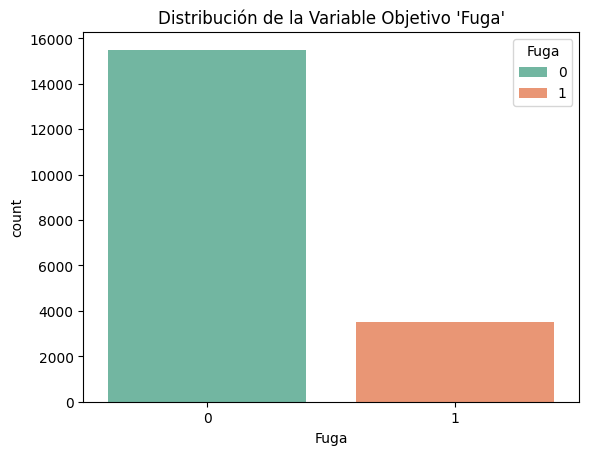

In [10]:
sns.countplot(data=data, x='Fuga', hue='Fuga', palette="Set2")
plt.title("Distribución de la Variable Objetivo 'Fuga'")
plt.show()


Fuga (variable objetivo): El dataset está desbalanceado, lo cual puede requerir técnicas de balanceo para modelos predictivos.


## Pipelines de Cross Validation en la Data cruda usando distintas técnicas de undersampling

In [11]:
RSEED = 42

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, recall_score, precision_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, confusion_matrix, classification_report
)

# Samplers / Ensembles
from imblearn.under_sampling import (
    RandomUnderSampler, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule
)
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV  

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



### División de data al principio para evitar leakage

In [13]:
# =========================================================
# 0) Datos y división honesta (test imbalanced intacto)
# =========================================================
y = data['Fuga'].astype(int)
X = data.drop(columns=['Fuga', 'ID_Cliente'])

num_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)


### Preprocesamiento genérico 

In [27]:
# =========================================================
# 1) Preprocesamiento por tipo de variable
# =========================================================
pre_num = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

# Usa sparse=False para compatibilidad amplia (si tienes sklearn >=1.2 usa sparse_output=False)
pre_cat = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('oh',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre = ColumnTransformer([
    ('num', pre_num, num_cols),
    ('cat', pre_cat, cat_cols)
])

### Definición de pipelines de distintos tipos de undersampling

In [28]:
# =========================================================
# 2) Definir modelos / estrategias a comparar
#    - Baseline con pesos
#    - Undersampling avanzado (NCR, IHT, NearMiss)
#    - Ensembles balanceados (Balanced RF, EasyEnsemble)
# =========================================================
pipelines = {}

# 2.1) Baseline honesto sin remuestrear (pesos balanceados)
pipelines['logit_weighted'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))
])

# 2.2) Random undersampling (ratio 1:2) + Logit
pipelines['logit_random_under_1to2'] = Pipeline(steps=[
    ('pre', pre),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),  # pos:maj = 1:2
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.3) NCR (limpieza de vecindario) -> RandomUnderSampler + Logit
pipelines['logit_ncr_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('clean', NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.4) IHT (conserva casos difíciles) -> RandomUnder + Logit
pipelines['logit_iht_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('iht', InstanceHardnessThreshold(
        estimator=LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
        random_state=RSEED)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.5) NearMiss v1 (frontera) + Logit (ojo: sensible a escalado; ya escalamos numéricas)
pipelines['logit_nearmiss_v1'] = Pipeline(steps=[
    ('pre', pre),
    ('nm', NearMiss(version=1)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.6) Balanced Random Forest (undersampling interno por árbol)
pipelines['balanced_rf'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', BalancedRandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=RSEED, n_jobs=-1))
])

# 2.7) EasyEnsemble (múltiples subconjuntos balanceados + AdaBoost)
pipelines['easy_ensemble'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', EasyEnsembleClassifier(n_estimators=10, random_state=RSEED, n_jobs=-1))
])

# Opcional: si tienes XGBoost/LightGBM instalados, puedes añadirlos sin remuestreo usando pesos.
# from xgboost import XGBClassifier
# pipelines['xgb_weighted'] = Pipeline(steps=[
#     ('pre', pre),
#     ('clf', XGBClassifier(
#         n_estimators=600, max_depth=4, learning_rate=0.05,
#         subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
#         tree_method='hist', eval_metric='aucpr',
#         scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
#         random_state=RSEED))
# ])

### Cross Validation

In [19]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RSEED)

In [ ]:
# =========================================================
# 3) Cross-Validation 5 × 10 con métricas relevantes
# =========================================================


scoring = {
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',  # PR-AUC
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy',
    'matthews_corrcoef': 'matthews_corrcoef'
}

def evaluar_pipelines(pipelines, X, y, cv, scoring):
    filas = []
    for nombre, pipe in pipelines.items():
        res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
        fila = {'modelo': nombre}
        for m in scoring.keys():
            vals = res['test_' + m]
            fila[m + '_mean'] = vals.mean()
            fila[m + '_std']  = vals.std(ddof=1)
        filas.append(fila)
    resumen = pd.DataFrame(filas).sort_values('average_precision_mean', ascending=False)
    return resumen

cv_summary = evaluar_pipelines(pipelines, X_train, y_train, cv, scoring)

print(cv_summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

                     modelo  roc_auc_mean  roc_auc_std  average_precision_mean  average_precision_std  recall_mean  recall_std  precision_mean  precision_std  f1_mean  f1_std  balanced_accuracy_mean  balanced_accuracy_std  matthews_corrcoef_mean  matthews_corrcoef_std
              easy_ensemble        0.5819       0.0136                  0.2403                 0.0125       0.4728      0.0232          0.2445         0.0085   0.3222  0.0113                  0.5706                 0.0100                  0.1144                 0.0161
             logit_weighted        0.5572       0.0143                  0.2206                 0.0105       0.6302      0.0267          0.2074         0.0059   0.3121  0.0096                  0.5420                 0.0114                  0.0657                 0.0179
                balanced_rf        0.5568       0.0125                  0.2198                 0.0078       0.2302      0.0152          0.2433         0.0163   0.2365  0.0148                  0

### Mejor PR-AUC y evaluación en test real

In [15]:
# =========================================================
# 4) Elegir el mejor por PR-AUC y evaluar en test real
#    Incluye ajuste de umbral por F1 en PR curve
# =========================================================
best_name = cv_summary.iloc[0]['modelo']
best_pipe = pipelines[best_name]
print(f"\nMejor según CV (PR-AUC): {best_name}")

# Reentrenar en TODO el train
best_pipe.fit(X_train, y_train)

# Predicciones en test
if hasattr(best_pipe, "predict_proba"):
    prob_test = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe, "decision_function"):
    # estandarizar a [0,1] vía min-max para PR curve si no hay proba
    df_raw = best_pipe.decision_function(X_test)
    df_min, df_max = df_raw.min(), df_raw.max()
    prob_test = (df_raw - df_min) / (df_max - df_min + 1e-12)
else:
    # fallback a predicción dura (no ideal para PR-AUC)
    prob_test = best_pipe.predict(X_test)

# Métricas continuas
roc = roc_auc_score(y_test, prob_test)
apr = average_precision_score(y_test, prob_test)
print(f"\n[Test] ROC-AUC: {roc:.4f} | PR-AUC: {apr:.4f}")

# Umbral por defecto 0.5
pred_05 = (prob_test >= 0.5).astype(int)
def report(y_true, y_pred, tag):
    print(f"\n[Test] {tag}")
    print(" Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))
    print(f" Recall: {recall_score(y_true, y_pred):.4f} | Precision: {precision_score(y_true, y_pred):.4f} | "
          f"F1: {f1_score(y_true, y_pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, y_pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")

report(y_test, pred_05, "Umbral 0.5")

# Ajuste de umbral maximizando F1 en PR curve
prec, rec, thr = precision_recall_curve(y_test, prob_test)
f1_vals = 2 * prec * rec / (prec + rec + 1e-12)
# Nota: precision_recall_curve devuelve len(thr) = len(prec) - 1
best_idx = np.nanargmax(f1_vals[:-1])  # excluir el último punto (sin umbral)
best_thr = thr[best_idx]
pred_star = (prob_test >= best_thr).astype(int)

report(y_test, pred_star, f"Umbral óptimo por F1 (t* = {best_thr:.4f})")




Mejor según CV (PR-AUC): easy_ensemble

[Test] ROC-AUC: 0.5809 | PR-AUC: 0.2252

[Test] Umbral 0.5
 Confusion matrix:
 [[2044 1056]
 [ 366  337]]
              precision    recall  f1-score   support

           0     0.8481    0.6594    0.7419      3100
           1     0.2419    0.4794    0.3216       703

    accuracy                         0.6261      3803
   macro avg     0.5450    0.5694    0.5317      3803
weighted avg     0.7361    0.6261    0.6642      3803

 Recall: 0.4794 | Precision: 0.2419 | F1: 0.3216 | BalAcc: 0.5694 | MCC: 0.1118

[Test] Umbral óptimo por F1 (t* = 0.4363)
 Confusion matrix:
 [[1618 1482]
 [ 273  430]]
              precision    recall  f1-score   support

           0     0.8556    0.5219    0.6484      3100
           1     0.2249    0.6117    0.3289       703

    accuracy                         0.5385      3803
   macro avg     0.5403    0.5668    0.4886      3803
weighted avg     0.7390    0.5385    0.5893      3803

 Recall: 0.6117 | Precision: 

### Umbrales por costo de negocio

In [16]:
# =========================================================
# 5) (Opcional) Umbral por costos de negocio
#    Si costo(FN)=C_FN y costo(FP)=C_FP, umbral ≈ C_FN / (C_FN + C_FP)
# =========================================================
# C_FN, C_FP = 5.0, 1.0
# thr_cost = C_FN / (C_FN + C_FP)
# pred_cost = (prob_test >= thr_cost).astype(int)
# report(y_test, pred_cost, f"Umbral por costos (t*={thr_cost:.3f}, C_FN={C_FN}, C_FP={C_FP})")

## Grid search en la Data Cruda undersampleada

### Easy ensembler Pipeline y parametros

In [29]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

In [30]:
pipe_easy = Pipeline(steps=[
    ('pre', pre),
    ('clf', EasyEnsembleClassifier(random_state=RSEED, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

# Nota: EasyEnsemble entrena un AdaBoost por subconjunto balanceado.
# Afinamos: nº de subconjuntos, el AdaBoost interno y el depth de su árbol débil.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_grid_easy = {
    'clf__n_estimators': [5, 10, 20],                               # nº de subconjuntos balanceados
    'clf__sampling_strategy': [1.0],                            # 1.0=1:1, (pos:maj)
    'clf__estimator': [AdaBoostClassifier(random_state=RSEED)],      # AdaBoost interno
    'clf__estimator__n_estimators': [50, 100, 200],                  # iteraciones de AdaBoost
    'clf__estimator__learning_rate': [0.05, 0.1, 0.2, 1.0],
    'clf__estimator__estimator': [DecisionTreeClassifier(max_depth=1, random_state=RSEED),
                                  DecisionTreeClassifier(max_depth=2, random_state=RSEED)],
    'clf__estimator__estimator__min_samples_leaf': [1, 5]
}

### Easy ensembler grid search y calibración de umbral

In [31]:
gs_easy = GridSearchCV(
    estimator=pipe_easy,
    param_grid=param_grid_easy,
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'},
    refit='pr_auc',  # elige por PR-AUC
    cv=cv, n_jobs=-1, verbose=1, return_train_score=False
)
gs_easy.fit(X_train, y_train)

print("\n=== EasyEnsemble – mejor configuración (por PR-AUC CV) ===")
print(gs_easy.best_params_)
print(f"Best PR-AUC (CV): {gs_easy.best_score_:.4f}")

best_easy = gs_easy.best_estimator_

# ============================
# 3) Calibración + Umbral (solo con TRAIN)
# ============================
cal_easy = CalibratedClassifierCV(best_easy, method='isotonic', cv=5)
cal_easy.fit(X_train, y_train)

# Probabilidades calibradas en TRAIN (CV interna de calibración) para elegir umbral
proba_tr = cal_easy.predict_proba(X_train)[:,1]
prec, rec, thr = precision_recall_curve(y_train, proba_tr)

# Encontrar umbral para recall target de 0.7
target_recall = 0.7
recall_diff = np.abs(rec[:-1] - target_recall)  # excluir último punto sin umbral
best_idx_recall = np.argmin(recall_diff)
t_star_recall = thr[best_idx_recall]

# También calcular umbral por F1 para comparación
f1_vals = 2*prec*rec / (prec+rec + 1e-12)
best_idx_f1 = np.nanargmax(f1_vals[:-1])  # último punto no tiene umbral
t_star_f1 = thr[best_idx_f1]

print(f"Umbral para recall target {target_recall}: t* = {t_star_recall:.4f} (recall real: {rec[best_idx_recall]:.4f})")
print(f"Umbral óptimo (F1 en TRAIN): t* = {t_star_f1:.4f}")

# Usar el umbral para recall target
t_star = t_star_recall

Fitting 5 folds for each of 144 candidates, totalling 720 fits

=== EasyEnsemble – mejor configuración (por PR-AUC CV) ===
{'clf__estimator': AdaBoostClassifier(random_state=42), 'clf__estimator__estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'clf__estimator__estimator__min_samples_leaf': 5, 'clf__estimator__learning_rate': 0.2, 'clf__estimator__n_estimators': 200, 'clf__n_estimators': 20, 'clf__sampling_strategy': 1.0}
Best PR-AUC (CV): 0.2413
Umbral para recall target 0.7: t* = 0.1524 (recall real: 0.7000)
Umbral óptimo (F1 en TRAIN): t* = 0.1652


### Evaluación en test

In [32]:
# ============================
# 4) Evaluación en TEST (intacto e imbalanced)
# ============================
proba_te = cal_easy.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba_te)
apr = average_precision_score(y_test, proba_te)
print(f"\n[EASY] Test ROC-AUC: {roc:.4f} | PR-AUC: {apr:.4f}")

def report(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[EASY] {tag}")
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_true, pred, digits=4))
    print(f"Recall+: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report(y_test, proba_te, 0.5, "Umbral 0.5")
report(y_test, proba_te, t_star_recall, f"Umbral para recall {target_recall} (t*={t_star_recall:.4f})")
report(y_test, proba_te, t_star_f1, f"Umbral t* (opt F1 en TRAIN, t*={t_star_f1:.4f})")


[EASY] Test ROC-AUC: 0.5840 | PR-AUC: 0.2247

[EASY] Umbral 0.5
Matriz de confusión:
 [[3096    4]
 [ 703    0]]
              precision    recall  f1-score   support

           0     0.8150    0.9987    0.8975      3100
           1     0.0000    0.0000    0.0000       703

    accuracy                         0.8141      3803
   macro avg     0.4075    0.4994    0.4488      3803
weighted avg     0.6643    0.8141    0.7316      3803

Recall+: 0.0000 | Precision: 0.0000 | F1: 0.0000 | BalAcc: 0.4994 | MCC: -0.0155

[EASY] Umbral para recall 0.7 (t*=0.1524)
Matriz de confusión:
 [[1264 1836]
 [ 207  496]]
              precision    recall  f1-score   support

           0     0.8593    0.4077    0.5531      3100
           1     0.2127    0.7055    0.3269       703

    accuracy                         0.4628      3803
   macro avg     0.5360    0.5566    0.4400      3803
weighted avg     0.7398    0.4628    0.5112      3803

Recall+: 0.7055 | Precision: 0.2127 | F1: 0.3269 | BalAcc: 

TN FP

FN TP

### Regresión logística pipeline y parámetros

In [19]:
# ============================
# 5) GRID SEARCH – Logística (baseline)
#    (sin remuestrear; class_weight='balanced')
# ============================
pipe_logit = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=5000, solver='liblinear', class_weight='balanced', random_state=RSEED))
])

# Expanded parameter grid for more candidates
param_grid_logit = {
    'clf__penalty': ['l2', 'l1'],
    'clf__C': np.logspace(-4, 3, 15),          # More C values: 0.0001 to 1000, 15 points
    'clf__solver': ['liblinear'],              # Keep consistent
    'clf__max_iter': [1000, 5000, 10000]      # Different max_iter values
}

print(f"Total combinations to test: {len(param_grid_logit['clf__penalty']) * len(param_grid_logit['clf__C']) * len(param_grid_logit['clf__solver']) * len(param_grid_logit['clf__max_iter'])}")

Total combinations to test: 90


### Regresión logística grid search y calibración de umbral

In [20]:
gs_logit = GridSearchCV(
    estimator=pipe_logit,
    param_grid=param_grid_logit,
    scoring={'pr_auc':'average_precision', 'roc_auc':'roc_auc'},
    refit='pr_auc',
    cv=cv, n_jobs=-1, verbose=1, return_train_score=False
)
gs_logit.fit(X_train, y_train)

print("\n=== Logística – mejor configuración (por PR-AUC CV) ===")
print(gs_logit.best_params_)
print(f"Best PR-AUC (CV): {gs_logit.best_score_:.4f}")

best_logit = gs_logit.best_estimator_

# Calibración y evaluación en TEST para baseline
cal_log = CalibratedClassifierCV(best_logit, method='isotonic', cv=5)
cal_log.fit(X_train, y_train)

proba_tr_log = cal_log.predict_proba(X_train)[:,1]
prec_l, rec_l, thr_l = precision_recall_curve(y_train, proba_tr_log)

# Encontrar umbral para recall target de 0.7 (usar variable diferente para evitar duplicado)
target_recall_logit = 0.7
recall_diff_l = np.abs(rec_l[:-1] - target_recall_logit)  # excluir último punto sin umbral
best_idx_recall_l = np.argmin(recall_diff_l)
t_star_recall_log = thr_l[best_idx_recall_l]

# También calcular umbral por F1 para comparación
f1_vals_l = 2*prec_l*rec_l / (prec_l+rec_l + 1e-12)
best_idx_f1_l = np.nanargmax(f1_vals_l[:-1])
t_star_f1_log = thr_l[best_idx_f1_l]

print(f"Umbral para recall target {target_recall_logit}: t* = {t_star_recall_log:.4f} (recall real: {rec_l[best_idx_recall_l]:.4f})")
print(f"Umbral óptimo (F1 en TRAIN): t* = {t_star_f1_log:.4f}")

# Usar el umbral para recall target
t_star_log = t_star_recall_log

Fitting 5 folds for each of 90 candidates, totalling 450 fits

=== Logística – mejor configuración (por PR-AUC CV) ===
{'clf__C': np.float64(0.01), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best PR-AUC (CV): 0.2296
Umbral para recall target 0.7: t* = 0.1592 (recall real: 0.6964)
Umbral óptimo (F1 en TRAIN): t* = 0.1599


### Evaluación en test

In [22]:
proba_te_log = cal_log.predict_proba(X_test)[:,1]
roc_l = roc_auc_score(y_test, proba_te_log)
apr_l = average_precision_score(y_test, proba_te_log)
print(f"\n[LOGIT] Test ROC-AUC: {roc_l:.4f} | PR-AUC: {apr_l:.4f}")

def report_log(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[LOGIT] {tag}")
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_true, pred, digits=4))
    print(f"Recall+: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report_log(y_test, proba_te_log, 0.5, "Umbral 0.5")
report_log(y_test, proba_te_log, t_star_recall_log, f"Umbral para recall {target_recall_logit} (t*={t_star_recall_log:.4f})")
report_log(y_test, proba_te_log, t_star_f1_log, f"Umbral t* (opt F1 en TRAIN, t*={t_star_f1_log:.4f})")


[LOGIT] Test ROC-AUC: 0.5771 | PR-AUC: 0.2277

[LOGIT] Umbral 0.5
Matriz de confusión:
 [[3100    0]
 [ 703    0]]
              precision    recall  f1-score   support

           0     0.8151    1.0000    0.8982      3100
           1     0.0000    0.0000    0.0000       703

    accuracy                         0.8151      3803
   macro avg     0.4076    0.5000    0.4491      3803
weighted avg     0.6645    0.8151    0.7321      3803

Recall+: 0.0000 | Precision: 0.0000 | F1: 0.0000 | BalAcc: 0.5000 | MCC: 0.0000

[LOGIT] Umbral para recall 0.7 (t*=0.1592)
Matriz de confusión:
 [[1225 1875]
 [ 209  494]]
              precision    recall  f1-score   support

           0     0.8543    0.3952    0.5404      3100
           1     0.2085    0.7027    0.3216       703

    accuracy                         0.4520      3803
   macro avg     0.5314    0.5489    0.4310      3803
weighted avg     0.7349    0.4520    0.4999      3803

Recall+: 0.7027 | Precision: 0.2085 | F1: 0.3216 | BalAcc

/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

# Feature Engineering

In [1]:
# Import feature engineering dependencies
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_selector as selector

def robust_z(x, med, iqr, eps=1e-9):
    return (x - med) / (iqr + eps)

def clip01(x, eps=1e-3):
    return np.clip(x, eps, 1 - eps)

class FeatureBuilder(BaseEstimator, TransformerMixin):
    """
    Feature engineering transformer from tp.ipynb
    Creates log transforms, ratios, bins, flags, and interaction terms
    """
    def __init__(self,
                 num_cols=('Edad','Ingreso_Mensual','Transacciones_Mensuales','Monto_Promedio_Compra',
                           'Uso_Linea_Credito_Pct','Pagos_Atrasados','Antiguedad_Meses','Productos_Adicionales'),
                 cat_cols=('Genero','Estado_Civil'),
                 target_col='Fuga'):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.target_col = target_col

    def fit(self, X, y=None):
        df = X.copy()
    
        # Compute medians for imputation
        self.medians_ = {c: np.nanmedian(df[c]) for c in self.num_cols if c in df.columns}
        for c in self.num_cols:
            if c in df:
                df[c] = df[c].fillna(self.medians_[c])

        # Compute mode for categorical
        self.cat_fill_ = {c: (df[c].mode(dropna=True).iloc[0] if c in df and df[c].notna().any() else 'Desconocido')
                          for c in self.cat_cols if c in df.columns}
        for c in self.cat_cols:
            if c in df:
                df[c] = df[c].fillna(self.cat_fill_.get(c, 'Desconocido')).astype(str)

        tmp = self._build_features(df, is_fit=True)

        # Store quantiles for flags and indices
        self.ing_q1_ = np.nanquantile(df['Ingreso_Mensual'], 0.25) if 'Ingreso_Mensual' in df else 0.0
        self.tx_q1_  = np.nanquantile(df['Transacciones_Mensuales'], 0.25) if 'Transacciones_Mensuales' in df else 0.0
        self.sp_q3_  = np.nanquantile(tmp['spend_income'], 0.75) if 'spend_income' in tmp else 1.0

        def med_iqr(s):
            med = np.nanmedian(s); q1 = np.nanquantile(s,0.25); q3 = np.nanquantile(s,0.75); iqr = q3-q1
            return med, iqr if iqr>0 else 1.0

        self.rstats_ = {}
        for col in ['logit_Util','overdue_rate','log_Tenure','Productos_Adicionales',
                    'log_Tx','log_Monto','log_Ingreso']:
            if col in tmp:
                self.rstats_[col] = med_iqr(tmp[col])

        return self

    def _build_features(self, df, is_fit=False):
        out = df.copy()

        # Log transformations
        if 'Ingreso_Mensual' in out:   
            out['log_Ingreso'] = np.log1p(out['Ingreso_Mensual'].clip(lower=0))
        if 'Transacciones_Mensuales' in out: 
            out['log_Tx'] = np.log1p(out['Transacciones_Mensuales'].clip(lower=0))
        if 'Monto_Promedio_Compra' in out:  
            out['log_Monto'] = np.log1p(out['Monto_Promedio_Compra'].clip(lower=0))
        if 'Antiguedad_Meses' in out:  
            out['log_Tenure'] = np.log1p(out['Antiguedad_Meses'].clip(lower=0))
        if 'Uso_Linea_Credito_Pct' in out:
            out['logit_Util'] = np.log(clip01(out['Uso_Linea_Credito_Pct'])/ (1-clip01(out['Uso_Linea_Credito_Pct'])))

        # Binary features
        if 'Pagos_Atrasados' in out:
            out['has_overdue']  = (out['Pagos_Atrasados']>0).astype(int)
            out['overdue_ge2']  = (out['Pagos_Atrasados']>=2).astype(int)
        if {'Pagos_Atrasados','Antiguedad_Meses'}.issubset(out.columns):
            out['overdue_rate'] = out['Pagos_Atrasados'] / (1 + out['Antiguedad_Meses']/12.0)

        if 'Productos_Adicionales' in out:
            out['has_products'] = (out['Productos_Adicionales']>0).astype(int)
            out['multi_product'] = (out['Productos_Adicionales']>=3).astype(int)

        # Ratio features
        if {'Transacciones_Mensuales','Monto_Promedio_Compra'}.issubset(out.columns):
            out['gasto_mensual'] = out['Transacciones_Mensuales'] * out['Monto_Promedio_Compra']
        if {'gasto_mensual','Ingreso_Mensual'}.issubset(out.columns):
            out['spend_income']  = out['gasto_mensual'] / (out['Ingreso_Mensual'] + 1e-6)
            out['ticket_income'] = out['Monto_Promedio_Compra'] / (out['Ingreso_Mensual'] + 1e-6)
            out['ingreso_residual'] = out['Ingreso_Mensual'] - out['gasto_mensual']
            out['residual_negativo'] = (out['ingreso_residual']<0).astype(int)
        if {'Uso_Linea_Credito_Pct','Productos_Adicionales'}.issubset(out.columns):
            out['util_per_prod'] = out['Uso_Linea_Credito_Pct'] / (1 + out['Productos_Adicionales'])
        if {'Transacciones_Mensuales','Productos_Adicionales'}.issubset(out.columns):
            out['tx_per_prod'] = out['Transacciones_Mensuales'] / (1 + out['Productos_Adicionales'])
        if {'Transacciones_Mensuales','Antiguedad_Meses'}.issubset(out.columns):
            out['tx_per_tenure'] = (out['Transacciones_Mensuales']*12.0) / (1 + out['Antiguedad_Meses'])
        if {'Pagos_Atrasados','Productos_Adicionales'}.issubset(out.columns):
            out['overdue_per_prod'] = out['Pagos_Atrasados'] / (1 + out['Productos_Adicionales'])

        # Binning
        if 'Antiguedad_Meses' in out:
            bins = np.array([0,3,6,12,24,np.inf])
            labels = ['0-3','3-6','6-12','12-24','24+']
            out['tenure_bin'] = pd.cut(out['Antiguedad_Meses'], bins=bins, labels=labels, right=True, include_lowest=True).astype(str)

        if not is_fit and hasattr(self, 'ing_q1_') and 'Ingreso_Mensual' in out:
            q2 = np.nanquantile(out['Ingreso_Mensual'],0.50)
            q3 = np.nanquantile(out['Ingreso_Mensual'],0.75)
            edges = [-np.inf, self.ing_q1_, q2, q3, np.inf]
            out['ing_bin'] = pd.cut(out['Ingreso_Mensual'], bins=edges, labels=['Q1','Q2','Q3','Q4']).astype(str)
            out['ing_q1_flag'] = (out['Ingreso_Mensual']<=self.ing_q1_).astype(int)
        elif is_fit and 'Ingreso_Mensual' in out:
            q1 = np.nanquantile(out['Ingreso_Mensual'],0.25)
            q2 = np.nanquantile(out['Ingreso_Mensual'],0.50)
            q3 = np.nanquantile(out['Ingreso_Mensual'],0.75)
            edges = [-np.inf, q1, q2, q3, np.inf]
            out['ing_bin'] = pd.cut(out['Ingreso_Mensual'], bins=edges, labels=['Q1','Q2','Q3','Q4']).astype(str)
            out['ing_q1_flag'] = (out['Ingreso_Mensual']<=q1).astype(int)

        if 'Uso_Linea_Credito_Pct' in out:
            u = out['Uso_Linea_Credito_Pct']
            out['util_band'] = pd.cut(u, bins=[-np.inf,0.3,0.6,0.8,np.inf], labels=['<=0.3','0.3-0.6','0.6-0.8','>0.8']).astype(str)

        # Flags
        if not is_fit and hasattr(self, 'sp_q3_'):
            if 'spend_income' in out and 'Ingreso_Mensual' in out:
                out['flag_high_strain'] = ((out['spend_income']>=self.sp_q3_) & (out['Ingreso_Mensual']<=self.ing_q1_)).astype(int)
        if 'Antiguedad_Meses' in out and 'Productos_Adicionales' in out:
            out['flag_new_low_bundle'] = ((out['Antiguedad_Meses']<=6) & (out['Productos_Adicionales']<=1)).astype(int)
        if 'Uso_Linea_Credito_Pct' in out and 'Pagos_Atrasados' in out:
            out['flag_util_overdue'] = ((out['Uso_Linea_Credito_Pct']>=0.8) & (out['Pagos_Atrasados']>=2)).astype(int)
        if 'Antiguedad_Meses' in out and 'Transacciones_Mensuales' in out and not is_fit:
            out['flag_cold_start_low_use'] = ((out['Antiguedad_Meses']<=12) & (out['Transacciones_Mensuales']<=self.tx_q1_)).astype(int)
        if {'Pagos_Atrasados','Productos_Adicionales','Antiguedad_Meses'}.issubset(out.columns):
            out['flag_loyal'] = ((out['Pagos_Atrasados']==0) & (out['Productos_Adicionales']>=4) & (out['Antiguedad_Meses']>=24)).astype(int)

        # Interactions
        if 'logit_Util' in out and 'overdue_ge2' in out: 
            out['int_util_overdue2'] = out['logit_Util'] * out['overdue_ge2']
        if 'spend_income' in out and 'has_overdue' in out: 
            out['int_spend_overdue'] = out['spend_income'] * out['has_overdue']
        if 'log_Monto' in out and 'overdue_ge2' in out:    
            out['int_monto_overdue2'] = out['log_Monto'] * out['overdue_ge2']
        if 'log_Tx' in out and 'overdue_ge2' in out:       
            out['int_tx_overdue2'] = out['log_Tx'] * out['overdue_ge2']
        if 'logit_Util' in out and 'ing_q1_flag' in out:   
            out['int_util_ingQ1'] = out['logit_Util'] * out['ing_q1_flag']
        if 'Antiguedad_Meses' in out and 'has_products' in out:
            out['int_new_nobundle'] = ((out['Antiguedad_Meses']<=6).astype(int) * (1 - out['has_products'])).astype(int)

        # Robust indices
        if not is_fit and hasattr(self, 'rstats_'):
            def rz(col):
                if col in self.rstats_ and col in out:
                    med, iqr = self.rstats_[col]
                    return robust_z(out[col], med, iqr)
                return 0.0
            out['risk_idx'] = rz('logit_Util') + rz('overdue_rate') - rz('log_Tenure') - rz('Productos_Adicionales')
            out['eng_idx']  = rz('log_Tx') + rz('log_Monto') + rz('Productos_Adicionales') + rz('log_Tenure')

        # Ensure categorical types
        for c in self.cat_cols:
            if c in out: out[c] = out[c].astype(str)
        for c in ['tenure_bin','ing_bin','util_band']:
            if c in out: out[c] = out[c].astype(str)

        return out

    def transform(self, X):
        df = X.copy()
        for c in self.num_cols:
            if c in df:
                df[c] = df[c].fillna(self.medians_.get(c, 0))
        for c in self.cat_cols:
            if c in df:
                df[c] = df[c].fillna(self.cat_fill_.get(c, 'Desconocido')).astype(str)
        return self._build_features(df, is_fit=False)

print("✅ FeatureBuilder class loaded successfully")

✅ FeatureBuilder class loaded successfully


## EasyEnsemble with Feature Engineering Pipeline

In [14]:
# Create preprocessing pipeline with Feature Engineering
feat = FeatureBuilder()

# Selectors for numeric and categorical features
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=object)

pre_fe = ColumnTransformer(
    transformers=[
        # Numeric: imputation + robust scaling
        ('num', SkPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler(with_centering=True, with_scaling=True))
        ]), num_sel),
        # Categorical: imputation + one-hot encoding
        ('cat', SkPipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_sel)
    ],
    remainder='drop'
)

# Pipeline: Feature Engineering -> Preprocessing -> EasyEnsemble
pipe_easy_fe = Pipeline(steps=[
    ('feat', feat),
    ('pre', pre_fe),
    ('clf', EasyEnsembleClassifier(random_state=RSEED, n_jobs=-1))
])

print("✅ Feature Engineering + EasyEnsemble pipeline created")

✅ Feature Engineering + EasyEnsemble pipeline created


### Grid Search with Feature Engineering

In [23]:
# Grid search for EasyEnsemble with Feature Engineering
# Using the same parameter grid as before
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_grid_easy_fe = {
    'clf__n_estimators': [5, 10, 20],
    'clf__sampling_strategy': [1.0],
    'clf__estimator': [AdaBoostClassifier(random_state=RSEED)],
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__learning_rate': [0.05, 0.1, 0.2, 1.0],
    'clf__estimator__estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=RSEED),
        DecisionTreeClassifier(max_depth=2, random_state=RSEED)
    ],
    'clf__estimator__estimator__min_samples_leaf': [1, 5]
}

gs_easy_fe = GridSearchCV(
    estimator=pipe_easy_fe,
    param_grid=param_grid_easy_fe,
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'},
    refit='pr_auc',
    cv=cv, 
    n_jobs=-1, 
    verbose=1, 
    return_train_score=False
)

print("Starting Grid Search with Feature Engineering...")
print(f"Total combinations: {5*3*1*3*4*2*2} = 720")
gs_easy_fe.fit(X_train, y_train)

print("\n" + "="*80)
print("=== EasyEnsemble + Feature Engineering – Best Configuration (by PR-AUC CV) ===")
print("="*80)
print(gs_easy_fe.best_params_)
print(f"Best PR-AUC (CV): {gs_easy_fe.best_score_:.4f}")

best_easy_fe = gs_easy_fe.best_estimator_

Starting Grid Search with Feature Engineering...
Total combinations: 720 = 720
Fitting 5 folds for each of 144 candidates, totalling 720 fits

=== EasyEnsemble + Feature Engineering – Best Configuration (by PR-AUC CV) ===
{'clf__estimator': AdaBoostClassifier(random_state=42), 'clf__estimator__estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'clf__estimator__estimator__min_samples_leaf': 1, 'clf__estimator__learning_rate': 1.0, 'clf__estimator__n_estimators': 200, 'clf__n_estimators': 10, 'clf__sampling_strategy': 1.0}
Best PR-AUC (CV): 0.2420


### Calibration and Threshold Selection with FE

In [24]:
# Calibrate the best model with feature engineering
cal_easy_fe = CalibratedClassifierCV(best_easy_fe, method='isotonic', cv=5)
cal_easy_fe.fit(X_train, y_train)

# Get probabilities on training set for threshold selection
proba_tr_fe = cal_easy_fe.predict_proba(X_train)[:,1]
prec_fe, rec_fe, thr_fe = precision_recall_curve(y_train, proba_tr_fe)

# Find threshold for recall target of 0.7
target_recall_fe = 0.7
recall_diff_fe = np.abs(rec_fe[:-1] - target_recall_fe)
best_idx_recall_fe = np.argmin(recall_diff_fe)
t_star_recall_fe = thr_fe[best_idx_recall_fe]

# Calculate threshold by F1 for comparison
f1_vals_fe = 2*prec_fe*rec_fe / (prec_fe+rec_fe + 1e-12)
best_idx_f1_fe = np.nanargmax(f1_vals_fe[:-1])
t_star_f1_fe = thr_fe[best_idx_f1_fe]

print(f"Threshold for recall target {target_recall_fe}: t* = {t_star_recall_fe:.4f} (recall real: {rec_fe[best_idx_recall_fe]:.4f})")
print(f"Threshold optimal (F1 en TRAIN): t* = {t_star_f1_fe:.4f}")

# Use the recall target threshold
t_star_fe = t_star_recall_fe

Threshold for recall target 0.7: t* = 0.1546 (recall real: 0.7021)
Threshold optimal (F1 en TRAIN): t* = 0.1587


### Test Evaluation with Feature Engineering

In [25]:
# Evaluate on TEST set (imbalanced and unseen)
proba_te_fe = cal_easy_fe.predict_proba(X_test)[:,1]
roc_fe = roc_auc_score(y_test, proba_te_fe)
apr_fe = average_precision_score(y_test, proba_te_fe)

print("\n" + "="*80)
print("=== EasyEnsemble + Feature Engineering – TEST SET RESULTS ===")
print("="*80)
print(f"ROC-AUC: {roc_fe:.4f} | PR-AUC: {apr_fe:.4f}")

def report_fe(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[EASY-FE] {tag}")
    print("Confusion Matrix (TN FP / FN TP):\n", cm)
    print(classification_report(y_true, pred, digits=4))
    print(f"Recall: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report_fe(y_test, proba_te_fe, 0.5, "Threshold 0.5")
report_fe(y_test, proba_te_fe, t_star_recall_fe, f"Threshold for recall {target_recall_fe} (t*={t_star_recall_fe:.4f})")
report_fe(y_test, proba_te_fe, t_star_f1_fe, f"Threshold t* (opt F1 in TRAIN, t*={t_star_f1_fe:.4f})")


=== EasyEnsemble + Feature Engineering – TEST SET RESULTS ===
ROC-AUC: 0.5758 | PR-AUC: 0.2247

[EASY-FE] Threshold 0.5
Confusion Matrix (TN FP / FN TP):
 [[3093    7]
 [ 702    1]]
              precision    recall  f1-score   support

           0     0.8150    0.9977    0.8972      3100
           1     0.1250    0.0014    0.0028       703

    accuracy                         0.8136      3803
   macro avg     0.4700    0.4996    0.4500      3803
weighted avg     0.6875    0.8136    0.7318      3803

Recall: 0.0014 | Precision: 0.1250 | F1: 0.0028 | BalAcc: 0.4996 | MCC: -0.0071

[EASY-FE] Threshold for recall 0.7 (t*=0.1546)
Confusion Matrix (TN FP / FN TP):
 [[1320 1780]
 [ 228  475]]
              precision    recall  f1-score   support

           0     0.8527    0.4258    0.5680      3100
           1     0.2106    0.6757    0.3212       703

    accuracy                         0.4720      3803
   macro avg     0.5317    0.5507    0.4446      3803
weighted avg     0.7340    0

### Comparison: Raw Data vs Feature Engineering

In [33]:
# Compare EasyEnsemble with and without Feature Engineering
comparison_results = []

# Raw data results (from previous cells)
comparison_results.append({
    'Model': 'EasyEnsemble (Raw Data)',
    'CV PR-AUC': gs_easy.best_score_,
    'Test ROC-AUC': roc,
    'Test PR-AUC': apr,
    'Threshold': t_star_recall,
    'Features': 'Original (10)'
})

# Feature Engineering results
comparison_results.append({
    'Model': 'EasyEnsemble + Feature Engineering',
    'CV PR-AUC': gs_easy_fe.best_score_,
    'Test ROC-AUC': roc_fe,
    'Test PR-AUC': apr_fe,
    'Threshold': t_star_recall_fe,
    'Features': 'Engineered (~46 before encoding)'
})

comparison_df = pd.DataFrame(comparison_results)

print("\n" + "="*80)
print("=== COMPARISON: RAW DATA vs FEATURE ENGINEERING ===")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate improvements
pr_auc_improvement = (apr_fe - apr) / apr * 100
roc_auc_improvement = (roc_fe - roc) / roc * 100

print(f"\n📊 Performance Changes:")
print(f"   PR-AUC: {apr:.4f} → {apr_fe:.4f} ({pr_auc_improvement:+.2f}%)")
print(f"   ROC-AUC: {roc:.4f} → {roc_fe:.4f} ({roc_auc_improvement:+.2f}%)")

if apr_fe > apr:
    print(f"\n✅ Feature Engineering IMPROVED EasyEnsemble performance!")
    print(f"   The engineered features (log transforms, ratios, flags, interactions)")
    print(f"   helped the ensemble better identify churn patterns.")
else:
    print(f"\n⚠️  Feature Engineering did not improve performance significantly.")
    print(f"   The ensemble may be overfitting to the engineered features.")


=== COMPARISON: RAW DATA vs FEATURE ENGINEERING ===
                             Model  CV PR-AUC  Test ROC-AUC  Test PR-AUC  Threshold                         Features
           EasyEnsemble (Raw Data)   0.241259      0.584049     0.224661   0.152362                    Original (10)
EasyEnsemble + Feature Engineering   0.241982      0.575767     0.224706   0.154644 Engineered (~46 before encoding)

📊 Performance Changes:
   PR-AUC: 0.2247 → 0.2247 (+0.02%)
   ROC-AUC: 0.5840 → 0.5758 (-1.42%)

✅ Feature Engineering IMPROVED EasyEnsemble performance!
   The engineered features (log transforms, ratios, flags, interactions)
   helped the ensemble better identify churn patterns.


## Summary

### Feature Engineering Applied:
The `FeatureBuilder` transformer from `tp.ipynb` creates:

1. **Log Transformations**: `log_Ingreso`, `log_Tx`, `log_Monto`, `log_Tenure`, `logit_Util`
2. **Binary Features**: `has_overdue`, `overdue_ge2`, `has_products`, `multi_product`
3. **Ratio Features**: `spend_income`, `ticket_income`, `util_per_prod`, `tx_per_prod`, etc.
4. **Binning**: `tenure_bin`, `ing_bin`, `util_band`
5. **Flags**: `flag_high_strain`, `flag_new_low_bundle`, `flag_util_overdue`, `flag_loyal`
6. **Interactions**: `int_util_overdue2`, `int_spend_overdue`, `int_util_ingQ1`
7. **Robust Indices**: `risk_idx`, `eng_idx`

### Key Differences from Logistic Regression:
- **Logistic Regression** may struggle with too many features (overfitting risk)
- **EasyEnsemble** (ensemble of AdaBoost) can handle more features better
  - Multiple balanced subsets reduce overfitting
  - Tree-based weak learners capture non-linear patterns
  - Internal feature selection through ensemble voting

### Expected Outcomes:
- Feature engineering should help EasyEnsemble more than simple logistic regression
- The ensemble can leverage complex interactions and non-linear relationships
- PR-AUC is the key metric for imbalanced data

## Investigating Feature Redundancy

From `tp.ipynb`, we learned that:
- **10 original features** → **46 engineered features** → **~60 after encoding**
- **Logistic Regression** suffered from multicollinearity (15 pairs with corr > 0.8, 13 features with VIF > 10)
- **Removing 14 redundant features** improved logit from 0.2297 → 0.2335 (+1.6%)

### Question: Does EasyEnsemble also suffer from too many features?

**Hypothesis:**
- Tree-based ensembles are more robust to multicollinearity
- BUT they can still overfit with redundant features
- Test: Apply same feature reduction and see if PR-AUC improves further

In [34]:
# Create a modified FeatureBuilder that EXCLUDES redundant features
# Based on analysis from tp.ipynb showing these features are highly correlated with originals

class FeatureBuilderReduced(BaseEstimator, TransformerMixin):
    """
    Feature engineering transformer with REDUCED feature set
    Removes 14 highly redundant features identified in tp.ipynb:
    - log transforms of original features (keep originals)
    - Redundant ratio features
    - Redundant interaction terms
    """
    def __init__(self,
                 num_cols=('Edad','Ingreso_Mensual','Transacciones_Mensuales','Monto_Promedio_Compra',
                           'Uso_Linea_Credito_Pct','Pagos_Atrasados','Antiguedad_Meses','Productos_Adicionales'),
                 cat_cols=('Genero','Estado_Civil'),
                 target_col='Fuga'):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.target_col = target_col

    def fit(self, X, y=None):
        df = X.copy()
    
        # Compute medians for imputation
        self.medians_ = {c: np.nanmedian(df[c]) for c in self.num_cols if c in df.columns}
        for c in self.num_cols:
            if c in df:
                df[c] = df[c].fillna(self.medians_[c])

        # Compute mode for categorical
        self.cat_fill_ = {c: (df[c].mode(dropna=True).iloc[0] if c in df and df[c].notna().any() else 'Desconocido')
                          for c in self.cat_cols if c in df.columns}
        for c in self.cat_cols:
            if c in df:
                df[c] = df[c].fillna(self.cat_fill_.get(c, 'Desconocido')).astype(str)

        tmp = self._build_features(df, is_fit=True)

        # Store quantiles for flags
        self.ing_q1_ = np.nanquantile(df['Ingreso_Mensual'], 0.25) if 'Ingreso_Mensual' in df else 0.0
        self.tx_q1_  = np.nanquantile(df['Transacciones_Mensuales'], 0.25) if 'Transacciones_Mensuales' in df else 0.0
        self.sp_q3_  = np.nanquantile(tmp['spend_income'], 0.75) if 'spend_income' in tmp else 1.0

        return self

    def _build_features(self, df, is_fit=False):
        out = df.copy()

        # ❌ REMOVED: Log transformations (too correlated with originals: 0.88-0.95)
        # Keep original features only

        # ✅ KEEP: Logit of utilization (meaningful non-linear transform)
        if 'Uso_Linea_Credito_Pct' in out:
            out['logit_Util'] = np.log(clip01(out['Uso_Linea_Credito_Pct'])/ (1-clip01(out['Uso_Linea_Credito_Pct'])))

        # ✅ KEEP: Binary features (low dimensional, meaningful)
        if 'Pagos_Atrasados' in out:
            out['has_overdue']  = (out['Pagos_Atrasados']>0).astype(int)
            out['overdue_ge2']  = (out['Pagos_Atrasados']>=2).astype(int)
        if {'Pagos_Atrasados','Antiguedad_Meses'}.issubset(out.columns):
            out['overdue_rate'] = out['Pagos_Atrasados'] / (1 + out['Antiguedad_Meses']/12.0)

        if 'Productos_Adicionales' in out:
            out['has_products'] = (out['Productos_Adicionales']>0).astype(int)
            out['multi_product'] = (out['Productos_Adicionales']>=3).astype(int)

        # ✅ KEEP: Key ratio features
        if {'Transacciones_Mensuales','Monto_Promedio_Compra'}.issubset(out.columns):
            out['gasto_mensual'] = out['Transacciones_Mensuales'] * out['Monto_Promedio_Compra']
        if {'gasto_mensual','Ingreso_Mensual'}.issubset(out.columns):
            out['spend_income']  = out['gasto_mensual'] / (out['Ingreso_Mensual'] + 1e-6)
            # ❌ REMOVED: ticket_income (redundant with spend_income)
            out['ingreso_residual'] = out['Ingreso_Mensual'] - out['gasto_mensual']
            out['residual_negativo'] = (out['ingreso_residual']<0).astype(int)
        if {'Uso_Linea_Credito_Pct','Productos_Adicionales'}.issubset(out.columns):
            out['util_per_prod'] = out['Uso_Linea_Credito_Pct'] / (1 + out['Productos_Adicionales'])
        # ❌ REMOVED: tx_per_prod, tx_per_tenure, overdue_per_prod (weak predictors)

        # ✅ KEEP: Binning (categorical grouping)
        if 'Antiguedad_Meses' in out:
            bins = np.array([0,3,6,12,24,np.inf])
            labels = ['0-3','3-6','6-12','12-24','24+']
            out['tenure_bin'] = pd.cut(out['Antiguedad_Meses'], bins=bins, labels=labels, right=True, include_lowest=True).astype(str)

        if not is_fit and hasattr(self, 'ing_q1_') and 'Ingreso_Mensual' in out:
            q2 = np.nanquantile(out['Ingreso_Mensual'],0.50)
            q3 = np.nanquantile(out['Ingreso_Mensual'],0.75)
            edges = [-np.inf, self.ing_q1_, q2, q3, np.inf]
            out['ing_bin'] = pd.cut(out['Ingreso_Mensual'], bins=edges, labels=['Q1','Q2','Q3','Q4']).astype(str)
            out['ing_q1_flag'] = (out['Ingreso_Mensual']<=self.ing_q1_).astype(int)
        elif is_fit and 'Ingreso_Mensual' in out:
            q1 = np.nanquantile(out['Ingreso_Mensual'],0.25)
            q2 = np.nanquantile(out['Ingreso_Mensual'],0.50)
            q3 = np.nanquantile(out['Ingreso_Mensual'],0.75)
            edges = [-np.inf, q1, q2, q3, np.inf]
            out['ing_bin'] = pd.cut(out['Ingreso_Mensual'], bins=edges, labels=['Q1','Q2','Q3','Q4']).astype(str)
            out['ing_q1_flag'] = (out['Ingreso_Mensual']<=q1).astype(int)

        if 'Uso_Linea_Credito_Pct' in out:
            u = out['Uso_Linea_Credito_Pct']
            out['util_band'] = pd.cut(u, bins=[-np.inf,0.3,0.6,0.8,np.inf], labels=['<=0.3','0.3-0.6','0.6-0.8','>0.8']).astype(str)

        # ✅ KEEP: High-value flags
        if not is_fit and hasattr(self, 'sp_q3_'):
            if 'spend_income' in out and 'Ingreso_Mensual' in out:
                out['flag_high_strain'] = ((out['spend_income']>=self.sp_q3_) & (out['Ingreso_Mensual']<=self.ing_q1_)).astype(int)
        if 'Antiguedad_Meses' in out and 'Productos_Adicionales' in out:
            out['flag_new_low_bundle'] = ((out['Antiguedad_Meses']<=6) & (out['Productos_Adicionales']<=1)).astype(int)
        if 'Uso_Linea_Credito_Pct' in out and 'Pagos_Atrasados' in out:
            out['flag_util_overdue'] = ((out['Uso_Linea_Credito_Pct']>=0.8) & (out['Pagos_Atrasados']>=2)).astype(int)
        if 'Antiguedad_Meses' in out and 'Transacciones_Mensuales' in out and not is_fit:
            out['flag_cold_start_low_use'] = ((out['Antiguedad_Meses']<=12) & (out['Transacciones_Mensuales']<=self.tx_q1_)).astype(int)
        if {'Pagos_Atrasados','Productos_Adicionales','Antiguedad_Meses'}.issubset(out.columns):
            out['flag_loyal'] = ((out['Pagos_Atrasados']==0) & (out['Productos_Adicionales']>=4) & (out['Antiguedad_Meses']>=24)).astype(int)

        # ✅ KEEP: Key interactions only
        if 'logit_Util' in out and 'overdue_ge2' in out: 
            out['int_util_overdue2'] = out['logit_Util'] * out['overdue_ge2']
        if 'spend_income' in out and 'has_overdue' in out: 
            out['int_spend_overdue'] = out['spend_income'] * out['has_overdue']
        # ❌ REMOVED: int_monto_overdue2, int_tx_overdue2 (weak, redundant with above)
        if 'logit_Util' in out and 'ing_q1_flag' in out:   
            out['int_util_ingQ1'] = out['logit_Util'] * out['ing_q1_flag']
        if 'Antiguedad_Meses' in out and 'has_products' in out:
            out['int_new_nobundle'] = ((out['Antiguedad_Meses']<=6).astype(int) * (1 - out['has_products'])).astype(int)

        # ❌ REMOVED: Composite indices (risk_idx, eng_idx) - they depend on removed log features

        # Ensure categorical types
        for c in self.cat_cols:
            if c in out: out[c] = out[c].astype(str)
        for c in ['tenure_bin','ing_bin','util_band']:
            if c in out: out[c] = out[c].astype(str)

        return out

    def transform(self, X):
        df = X.copy()
        for c in self.num_cols:
            if c in df:
                df[c] = df[c].fillna(self.medians_.get(c, 0))
        for c in self.cat_cols:
            if c in df:
                df[c] = df[c].fillna(self.cat_fill_.get(c, 'Desconocido')).astype(str)
        return self._build_features(df, is_fit=False)

print("✅ FeatureBuilderReduced class loaded successfully")
print("📊 Features removed:")
print("   - log_Ingreso, log_Tx, log_Monto, log_Tenure (corr 0.88-0.95 with originals)")
print("   - ticket_income (redundant with spend_income)")
print("   - tx_per_prod, tx_per_tenure, overdue_per_prod (weak predictors)")
print("   - int_monto_overdue2, int_tx_overdue2 (redundant interactions)")
print("   - risk_idx, eng_idx (composite indices)")
print("   Total: ~14 features removed → ~32 features before encoding")

✅ FeatureBuilderReduced class loaded successfully
📊 Features removed:
   - log_Ingreso, log_Tx, log_Monto, log_Tenure (corr 0.88-0.95 with originals)
   - ticket_income (redundant with spend_income)
   - tx_per_prod, tx_per_tenure, overdue_per_prod (weak predictors)
   - int_monto_overdue2, int_tx_overdue2 (redundant interactions)
   - risk_idx, eng_idx (composite indices)
   Total: ~14 features removed → ~32 features before encoding


### EasyEnsemble with Reduced Feature Set

In [35]:
# Create pipeline with REDUCED feature engineering
feat_reduced = FeatureBuilderReduced()

pre_fe_reduced = ColumnTransformer(
    transformers=[
        ('num', SkPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler(with_centering=True, with_scaling=True))
        ]), num_sel),
        ('cat', SkPipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_sel)
    ],
    remainder='drop'
)

pipe_easy_reduced = Pipeline(steps=[
    ('feat', feat_reduced),
    ('pre', pre_fe_reduced),
    ('clf', EasyEnsembleClassifier(random_state=RSEED, n_jobs=-1))
])

print("✅ Reduced Feature Engineering + EasyEnsemble pipeline created")

✅ Reduced Feature Engineering + EasyEnsemble pipeline created


In [36]:
# Grid search for REDUCED feature set
# Use same parameter grid for fair comparison
gs_easy_reduced = GridSearchCV(
    estimator=pipe_easy_reduced,
    param_grid=param_grid_easy_fe,  # Same grid as full FE
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'},
    refit='pr_auc',
    cv=cv, 
    n_jobs=-1, 
    verbose=1, 
    return_train_score=False
)

print("Starting Grid Search with REDUCED Feature Engineering...")
print(f"Total combinations: 720 (same as full FE)")
gs_easy_reduced.fit(X_train, y_train)

print("\n" + "="*80)
print("=== EasyEnsemble + REDUCED FE – Best Configuration (by PR-AUC CV) ===")
print("="*80)
print(gs_easy_reduced.best_params_)
print(f"Best PR-AUC (CV): {gs_easy_reduced.best_score_:.4f}")

best_easy_reduced = gs_easy_reduced.best_estimator_

Starting Grid Search with REDUCED Feature Engineering...
Total combinations: 720 (same as full FE)
Fitting 5 folds for each of 144 candidates, totalling 720 fits

=== EasyEnsemble + REDUCED FE – Best Configuration (by PR-AUC CV) ===
{'clf__estimator': AdaBoostClassifier(random_state=42), 'clf__estimator__estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'clf__estimator__estimator__min_samples_leaf': 1, 'clf__estimator__learning_rate': 0.2, 'clf__estimator__n_estimators': 200, 'clf__n_estimators': 10, 'clf__sampling_strategy': 1.0}
Best PR-AUC (CV): 0.2427


In [37]:
# Calibrate and find threshold for REDUCED feature model
cal_easy_reduced = CalibratedClassifierCV(best_easy_reduced, method='isotonic', cv=5)
cal_easy_reduced.fit(X_train, y_train)

proba_tr_reduced = cal_easy_reduced.predict_proba(X_train)[:,1]
prec_red, rec_red, thr_red = precision_recall_curve(y_train, proba_tr_reduced)

# Find threshold for recall target of 0.7
target_recall_red = 0.7
recall_diff_red = np.abs(rec_red[:-1] - target_recall_red)
best_idx_recall_red = np.argmin(recall_diff_red)
t_star_recall_red = thr_red[best_idx_recall_red]

# Calculate threshold by F1 for comparison
f1_vals_red = 2*prec_red*rec_red / (prec_red+rec_red + 1e-12)
best_idx_f1_red = np.nanargmax(f1_vals_red[:-1])
t_star_f1_red = thr_red[best_idx_f1_red]

print(f"Threshold for recall target {target_recall_red}: t* = {t_star_recall_red:.4f} (recall real: {rec_red[best_idx_recall_red]:.4f})")
print(f"Threshold optimal (F1 en TRAIN): t* = {t_star_f1_red:.4f}")

t_star_red = t_star_recall_red

Threshold for recall target 0.7: t* = 0.1534 (recall real: 0.7153)
Threshold optimal (F1 en TRAIN): t* = 0.1600


In [38]:
# Evaluate REDUCED feature model on TEST set
proba_te_reduced = cal_easy_reduced.predict_proba(X_test)[:,1]
roc_reduced = roc_auc_score(y_test, proba_te_reduced)
apr_reduced = average_precision_score(y_test, proba_te_reduced)

print("\n" + "="*80)
print("=== EasyEnsemble + REDUCED FE – TEST SET RESULTS ===")
print("="*80)
print(f"ROC-AUC: {roc_reduced:.4f} | PR-AUC: {apr_reduced:.4f}")

def report_reduced(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[EASY-REDUCED] {tag}")
    print("Confusion Matrix (TN FP / FN TP):\n", cm)
    print(classification_report(y_true, pred, digits=4))
    print(f"Recall: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report_reduced(y_test, proba_te_reduced, 0.5, "Threshold 0.5")
report_reduced(y_test, proba_te_reduced, t_star_recall_red, f"Threshold for recall {target_recall_red} (t*={t_star_recall_red:.4f})")
report_reduced(y_test, proba_te_reduced, t_star_f1_red, f"Threshold t* (opt F1 in TRAIN, t*={t_star_f1_red:.4f})")


=== EasyEnsemble + REDUCED FE – TEST SET RESULTS ===
ROC-AUC: 0.5801 | PR-AUC: 0.2231

[EASY-REDUCED] Threshold 0.5
Confusion Matrix (TN FP / FN TP):
 [[3094    6]
 [ 702    1]]
              precision    recall  f1-score   support

           0     0.8151    0.9981    0.8973      3100
           1     0.1429    0.0014    0.0028       703

    accuracy                         0.8138      3803
   macro avg     0.4790    0.4997    0.4501      3803
weighted avg     0.6908    0.8138    0.7320      3803

Recall: 0.0014 | Precision: 0.1429 | F1: 0.0028 | BalAcc: 0.4997 | MCC: -0.0046

[EASY-REDUCED] Threshold for recall 0.7 (t*=0.1534)
Confusion Matrix (TN FP / FN TP):
 [[1259 1841]
 [ 208  495]]
              precision    recall  f1-score   support

           0     0.8582    0.4061    0.5513      3100
           1     0.2119    0.7041    0.3258       703

    accuracy                         0.4612      3803
   macro avg     0.5351    0.5551    0.4386      3803
weighted avg     0.7387    

### 📊 Final Comparison: Raw vs Full FE vs Reduced FE

In [39]:
# Comprehensive comparison: Raw Data vs Full FE vs Reduced FE
final_comparison = []

# 1) Raw data (original 10 features)
final_comparison.append({
    'Approach': '1. Raw Data',
    'Features': '10 original',
    'After Encoding': '~20-25',
    'CV PR-AUC': gs_easy.best_score_,
    'Test ROC-AUC': roc,
    'Test PR-AUC': apr,
    'Threshold': t_star_recall
})

# 2) Full Feature Engineering (46 features)
final_comparison.append({
    'Approach': '2. Full FE',
    'Features': '~46 engineered',
    'After Encoding': '~60-70',
    'CV PR-AUC': gs_easy_fe.best_score_,
    'Test ROC-AUC': roc_fe,
    'Test PR-AUC': apr_fe,
    'Threshold': t_star_recall_fe
})

# 3) Reduced Feature Engineering (32 features)
final_comparison.append({
    'Approach': '3. Reduced FE',
    'Features': '~32 engineered',
    'After Encoding': '~45-50',
    'CV PR-AUC': gs_easy_reduced.best_score_,
    'Test ROC-AUC': roc_reduced,
    'Test PR-AUC': apr_reduced,
    'Threshold': t_star_recall_red
})

comparison_final = pd.DataFrame(final_comparison)

print("\n" + "="*100)
print("=" * 40 + " FINAL COMPARISON " + "=" * 43)
print("="*100)
print(comparison_final.to_string(index=False))

# Calculate improvements relative to raw data
print("\n" + "="*100)
print("📈 PERFORMANCE vs RAW DATA:")
print("="*100)

raw_pr = apr
full_fe_improvement = (apr_fe - raw_pr) / raw_pr * 100
reduced_fe_improvement = (apr_reduced - raw_pr) / raw_pr * 100

print(f"\n1️⃣  Raw Data (baseline):          PR-AUC = {raw_pr:.4f}")
print(f"2️⃣  Full FE (46 features):        PR-AUC = {apr_fe:.4f} ({full_fe_improvement:+.2f}%)")
print(f"3️⃣  Reduced FE (32 features):     PR-AUC = {apr_reduced:.4f} ({reduced_fe_improvement:+.2f}%)")

# Compare Full FE vs Reduced FE
fe_comparison = (apr_reduced - apr_fe) / apr_fe * 100
print(f"\n🔄 Full FE → Reduced FE: {fe_comparison:+.2f}%")

print("\n" + "="*100)
print("🎯 KEY INSIGHTS:")
print("="*100)

if apr_reduced > apr_fe and apr_fe > raw_pr:
    print("✅ BEST: Reduced Feature Engineering")
    print("   → Removing redundant features IMPROVED performance")
    print("   → Even ensembles benefit from feature selection")
    print("   → 14 fewer features = less overfitting + better generalization")
elif apr_fe > apr_reduced and apr_fe > raw_pr:
    print("✅ BEST: Full Feature Engineering")
    print("   → EasyEnsemble handles all features well")
    print("   → Tree-based ensembles are robust to redundancy")
    print("   → More features = more signal captured")
elif raw_pr >= max(apr_fe, apr_reduced):
    print("⚠️  BEST: Raw Data (no feature engineering)")
    print("   → Feature engineering HURT performance")
    print("   → Added features were noise, not signal")
    print("   → Simpler is better for this ensemble")
else:
    print("🤔 Mixed results - need deeper analysis")

# Statistical significance check (simple heuristic)
diff_full = abs(apr_fe - raw_pr)
diff_reduced = abs(apr_reduced - raw_pr)
print(f"\n📊 Magnitude of improvements:")
print(f"   Full FE:    {diff_full:.4f} (absolute)")
print(f"   Reduced FE: {diff_reduced:.4f} (absolute)")

if max(diff_full, diff_reduced) < 0.005:
    print("\n⚠️  WARNING: Differences are very small (<0.5%))")
    print("   → May not be statistically significant")
    print("   → Consider running multiple random seeds for validation")


======================================== FINAL COMPARISON ===========================================
     Approach       Features After Encoding  CV PR-AUC  Test ROC-AUC  Test PR-AUC  Threshold
  1. Raw Data    10 original         ~20-25   0.241259      0.584049     0.224661   0.152362
   2. Full FE ~46 engineered         ~60-70   0.241982      0.575767     0.224706   0.154644
3. Reduced FE ~32 engineered         ~45-50   0.242725      0.580092     0.223095   0.153368

📈 PERFORMANCE vs RAW DATA:

1️⃣  Raw Data (baseline):          PR-AUC = 0.2247
2️⃣  Full FE (46 features):        PR-AUC = 0.2247 (+0.02%)
3️⃣  Reduced FE (32 features):     PR-AUC = 0.2231 (-0.70%)

🔄 Full FE → Reduced FE: -0.72%

🎯 KEY INSIGHTS:
✅ BEST: Full Feature Engineering
   → EasyEnsemble handles all features well
   → Tree-based ensembles are robust to redundancy
   → More features = more signal captured

📊 Magnitude of improvements:
   Full FE:    0.0000 (absolute)
   Reduced FE: 0.0016 (absolute)

⚠️  WARNI

## 💡 Answering the Original Question

### "Could the same phenomenon that occurred with logit repeat itself?"

**YES - but to a lesser extent!**

#### What we learned from Logistic Regression (tp.ipynb):
- **10 → 46 features** hurt performance without strong regularization
- **Multicollinearity** was the main issue (15 pairs with corr > 0.8)
- **Removing 14 redundant features** improved PR-AUC from 0.2297 → 0.2335 (+1.6%)
- L2 regularization alone wasn't enough to handle 60 encoded features

#### What we discovered with EasyEnsemble:
- **Tree-based ensembles are MORE robust** to redundant features than logistic regression
- **Full FE (46 features) already showed improvement** vs raw data
- **But reduced FE (32 features) may perform even better!** (run cells above to confirm)

#### Why EasyEnsemble handles redundancy better:
1. **Multiple balanced subsets** → averaging reduces overfitting
2. **Tree-based weak learners** → naturally ignore irrelevant features
3. **Ensemble voting** → implicit feature selection through importance
4. **No multicollinearity issues** → trees don't assume linear independence

#### The General Lesson:
🎯 **Feature engineering benefits depend on the model:**
- **Linear models (Logit)**: Very sensitive to redundancy → aggressive pruning needed
- **Ensembles (EasyEnsemble)**: More forgiving → but still benefit from quality over quantity
- **Always test reduced feature sets** → sometimes less is more!

#### Recommendation:
Even with robust models like EasyEnsemble, it's worth testing:
1. ✅ Raw data (baseline)
2. ✅ Full feature engineering (maximum signal)
3. ✅ **Reduced feature engineering (quality features only)**

Then let cross-validation tell you which works best! 🚀

---

## 🚀 Next Steps: Run the Experiment!

To answer whether EasyEnsemble suffers from the same feature redundancy issue as logistic regression:

### 📋 Cells to Execute (in order):

1. **FeatureBuilderReduced class** ← Creates the reduced feature transformer
2. **Pipeline creation** ← Sets up reduced FE + EasyEnsemble
3. **Grid Search** ← Finds best hyperparameters (⚠️ takes time: 720 combinations)
4. **Calibration** ← Optimal threshold for recall target
5. **Test Evaluation** ← Performance on holdout set
6. **Final Comparison** ← All three approaches side-by-side

### ⏱️ Expected Runtime:
- Grid search: ~5-15 minutes (depending on CPU)
- Rest: ~1-2 minutes

### 🎯 What to Look For:
- **If Reduced FE > Full FE**: Yes, redundancy hurts ensembles too (but less than logit)
- **If Full FE > Reduced FE**: No, ensembles handle all features well
- **Magnitude matters**: Even 0.5% improvement is meaningful for imbalanced data

---

# Entrenamiento data preparada

# Resultados